In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualize validation losses

In [48]:
import plotly
import pandas as pd
import plotly.graph_objects as go

In [5]:
val_base = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/Base_valloss.csv")
val_da = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/DA_valloss.csv")
val_cda = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/CDA_valloss.csv")
val_fat = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/FAT_valloss.csv")
val_mat = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/MAT_valloss.csv")
val_fatda = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/FATDA_valloss.csv")
val_fatcda = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/FATCDA_valloss.csv")
val_matda = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/MAT_DA_valloss.csv")
val_matcda = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project/MAT_CDA_valloss.csv")

In [37]:
df_plot = pd.concat([val_base["Validation Loss"].rename("Base"), 
                     val_da["Validation Loss"].rename("DA"),
                     val_cda["Validation Loss"].rename("CDA"),
                     val_fat["Validation Loss"].rename("FAT"), 
                     val_mat["Validation Loss"].rename("MAT"), 
                     val_fatda["Validation Loss"].rename("FAT_DA"),
                     val_fatcda["Validation Loss"].rename("FAT_CDA"), 
                     val_matda["Validation Loss"].rename("MAT_DA"), 
                     val_matcda["Validation Loss"].rename("MAT_CDA"), 
                     val_matda["Epoch"]], axis=1)
df_plot.head()

,Base,DA,CDA,FAT,MAT,FAT_DA,FAT_CDA,MAT_DA,MAT_CDA,Epoch
0,0.327970,0.413292,0.699394,0.607398,0.547792,0.798635,1.218431,0.545350,0.810289,1
1,0.291837,0.402993,0.588752,0.572527,0.482418,0.772971,1.186759,0.524945,0.735927,2
2,0.290516,0.372565,0.559325,0.577601,0.446631,0.765280,1.140594,0.488717,0.719702,3
3,0.279966,0.343794,0.587215,0.594852,0.438758,0.780865,1.154668,0.515029,0.703586,4
4,0.269708,0.369431,0.539402,0.545801,0.411033,0.756084,1.140491,0.476607,0.692159,5


In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["Base"], name="Base"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["DA"], name="DA"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["CDA"], name="CDA"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["FAT"], name="FAT"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["MAT"], name="MAT"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["FAT_DA"], name="FAT+DA"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["MAT_DA"], name="MAT+DA"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["FAT_CDA"], name="FAT+CDA"))
fig.add_trace(go.Scatter(x=df_plot["Epoch"], y=df_plot["MAT_CDA"], name="MAT+CDA"))

fig.update_layout(title='Validation loss per model over training epochs',
                   xaxis_title='Epoch',
                   yaxis_title='Validation Loss (Cross-Entropy)')

fig.show()

# Visualize saliencies on test data

# Import libraries, set GPU

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import random
random.seed(123)

import time
import os

In [7]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Function to show an image tensor
def show(X, c):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        #plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap= c  )
        #plt.show()
    else:
        print('WRONG TENSOR SIZE')

# Load trained models and data

In [9]:
class LeNet(nn.Module):

    def __init__(self, kernel_size, pool_function, nfilters_conv1, nfilters_conv2):

        super(LeNet, self).__init__()
        self.nfilters_conv2 = nfilters_conv2

        # CL1:   1 x 28 x 28 (grayscale) -->    nfilters_conv1 x 28 x 28 
        self.conv1 = nn.Conv2d(1, nfilters_conv1,  kernel_size=kernel_size,  padding=kernel_size//2)

        # MP1: nfilters_conv1 x 28 x 28  -->    nfilters_conv1 x 14 x 14
        self.pool1  = pool_function(2,2)
        
        # CL2:   nfilters_conv1 x 14 x 14  -->    nfilters_conv2 x 14 x 14
        self.conv2 = nn.Conv2d(nfilters_conv1,  nfilters_conv2,  kernel_size=kernel_size,  padding=kernel_size//2)
        
        # MP2:  nfilters_conv2 x 14 x 14 -->    nfilters_conv2 x 7 x 7
        self.pool2 = pool_function(2,2)
        
        # LL1:   nfilters_conv2 x 7 x 7 -->  100 
        self.linear1 = nn.Linear((nfilters_conv2*7*7), 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):
        x = x.unsqueeze(1)

        # CL1:   
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 
        x = self.pool1(x)
        
        # CL2:   
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 
        x = self.pool2(x)

        # LL1:   
        x = x.view(-1, self.nfilters_conv2*7*7)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:  
        x = self.linear2(x)
        
        return x

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze()),  # Squeeze the data to remove the redundant channel dimension
                                ])

trainset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
)


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



In [11]:
model_base = torch.load("/content/drive/MyDrive/Deep Learning/Project/model.pckl")
model_fat = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_adv.pckl")
model_mat = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_advmix.pckl")
model_da = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_aug.pckl")
model_fatda = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_fatda.pckl")
model_matda = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_matda.pckl")
model_cda = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_augcom.pckl")
model_fatcda = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_fatcda.pckl")
model_matcda = torch.load("/content/drive/MyDrive/Deep Learning/Project/model_matcda.pckl")

# Specify Attack

In [12]:
!pip install advertorch
from advertorch.attacks import PGDAttack
from advertorch.utils import predict_from_logits

     |████████████████████████████████| 5.7MB 21.4MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=32c86030d0fa2d1aec23b21e9c3131846b358b85c432d2ed3c33ae6b58e93c69
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [13]:
adversary_base = PGDAttack(
    model_base, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_da = PGDAttack(
    model_da, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_fat = PGDAttack(
    model_fat, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_mat = PGDAttack(
    model_mat, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_cda = PGDAttack(
    model_cda, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_fatda = PGDAttack(
    model_fatda, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_matda = PGDAttack(
    model_matda, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_fatcda = PGDAttack(
    model_fatcda, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

adversary_matcda = PGDAttack(
    model_matcda, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

# Compute saliency and visualize

In [14]:
def compute_saliency(model, X):
    X = X.reshape(1, 28, 28)
    X = X.to(device)
    X.requires_grad_()
    Y = model(X)
    Y_idx = Y.argmax()
    Y_max = Y[0, Y_idx]
    Y_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(), dim=0) 
    saliency = saliency.reshape(28, 28)
    return saliency

In [15]:
def show_saliency_overlay(model, image, title):
    # make these smaller to increase the resolution
    dx, dy = 0.05, 0.05

    x = np.arange(0., 28.0, dx)
    y = np.arange(0., 28.0, dy)
    X, Y = np.meshgrid(x, y)
    
    extent = np.min(x), np.max(x), np.min(y), np.max(y)
    #fig = plt.figure(frameon=False)
    
    data = image.cpu().numpy()
    im1 = plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)
    saliency = compute_saliency(model, image).cpu().numpy()

    im2 = plt.imshow(saliency, cmap=plt.cm.viridis, alpha=.8, interpolation='bilinear',
                    extent=extent)
    plt.title(title)

Get the random sample to analyse

In [16]:
random.seed(321)
sample_ids = random.sample(range(len(trainset)), 10)

cln_data = torch.Tensor()
true_label = []

for id in sample_ids:
  cln_data = torch.cat((trainset[id][0].unsqueeze(2), cln_data), dim=-1)
  true_label.append(trainset[id][1])

cln_data = cln_data.transpose(0,2)
cln_data = cln_data.transpose(1,2)
true_label = torch.as_tensor(true_label)

cln_data, true_label = cln_data.to(device), true_label.to(device)

In [17]:
adv_da = adversary_da.perturb(cln_data, true_label)
pred_cln_da = predict_from_logits(model_da(cln_data))
pred_adv_da = predict_from_logits(model_da(adv_da))

adv_base = adversary_base.perturb(cln_data, true_label)
pred_cln_base = predict_from_logits(model_base(cln_data))
pred_adv_base = predict_from_logits(model_base(adv_base))

adv_fat = adversary_fat.perturb(cln_data, true_label)
pred_cln_fat = predict_from_logits(model_fat(cln_data))
pred_adv_fat = predict_from_logits(model_fat(adv_fat))

adv_mat = adversary_mat.perturb(cln_data, true_label)
pred_cln_mat = predict_from_logits(model_mat(cln_data))
pred_adv_mat = predict_from_logits(model_mat(adv_mat))

adv_cda = adversary_cda.perturb(cln_data, true_label)
pred_cln_cda = predict_from_logits(model_cda(cln_data))
pred_adv_cda = predict_from_logits(model_cda(adv_cda))

adv_fatda = adversary_fatda.perturb(cln_data, true_label)
pred_cln_fatda = predict_from_logits(model_fatda(cln_data))
pred_adv_fatda = predict_from_logits(model_fatda(adv_fatda))

adv_fatcda = adversary_fatcda.perturb(cln_data, true_label)
pred_cln_fatcda = predict_from_logits(model_fatcda(cln_data))
pred_adv_fatcda = predict_from_logits(model_fatcda(adv_fatcda))

adv_matda = adversary_matda.perturb(cln_data, true_label)
pred_cln_matda = predict_from_logits(model_matda(cln_data))
pred_adv_matda = predict_from_logits(model_matda(adv_matda))

adv_matcda = adversary_matcda.perturb(cln_data, true_label)
pred_cln_matcda = predict_from_logits(model_matcda(cln_data))
pred_adv_matcda = predict_from_logits(model_matcda(adv_matcda))

In [18]:
def plot_all_models(i):
  plt.figure(figsize=(25, 8))
  plt.subplot(2,9,1)
  show_saliency_overlay(model_base, cln_data[i], 'Clean Base \n Pred: ' + str(classes[pred_cln_base[i]])) 
  plt.subplot(2,9,2)
  show_saliency_overlay(model_da, cln_data[i], 'Clean DA \n Pred: ' + str(classes[pred_cln_da[i]]))   
  plt.subplot(2,9,3)
  show_saliency_overlay(model_fat, cln_data[i], 'Clean FAT \n Pred: ' + str(classes[pred_cln_fat[i]]))
  plt.subplot(2,9,4)
  show_saliency_overlay(model_mat, cln_data[i], 'Clean MAT \n Pred: ' + str(classes[pred_cln_mat[i]]))
  plt.subplot(2,9,5)
  show_saliency_overlay(model_cda, cln_data[i], 'Clean CDA \n Pred: ' + str(classes[pred_cln_cda[i]]))
  plt.subplot(2,9,6)
  show_saliency_overlay(model_fatda, cln_data[i], 'Clean FAT+DA \n Pred: ' + str(classes[pred_cln_fatda[i]]))
  plt.subplot(2,9,7)
  show_saliency_overlay(model_matda, cln_data[i], 'Clean MAT+DA \n Pred: ' + str(classes[pred_cln_matda[i]]))
  plt.subplot(2,9,8)
  show_saliency_overlay(model_fatcda, cln_data[i], 'Clean FAT+CDA \n Pred: ' + str(classes[pred_cln_fatcda[i]]))
  plt.subplot(2,9,9)
  show_saliency_overlay(model_matcda, cln_data[i], 'Clean MAT+CDA \n Pred: ' + str(classes[pred_cln_matcda[i]]))
  plt.subplot(2,9,10)
  show_saliency_overlay(model_base, adv_base[i], 'Adv Base \n Pred: ' + str(classes[pred_adv_base[i]])) 
  plt.subplot(2,9,11)
  show_saliency_overlay(model_da, adv_da[i], 'Adv DA \n Pred: ' + str(classes[pred_adv_da[i]]))   
  plt.subplot(2,9,12)
  show_saliency_overlay(model_fat, adv_fat[i], 'Adv FAT \n Pred: ' + str(classes[pred_adv_fat[i]]))
  plt.subplot(2,9,13)
  show_saliency_overlay(model_mat, adv_mat[i], 'Adv MAT \n Pred: ' + str(classes[pred_adv_mat[i]]))
  plt.subplot(2,9,14)
  show_saliency_overlay(model_cda, adv_cda[i], 'Adv CDA \n Pred: ' + str(classes[pred_adv_cda[i]]))
  plt.subplot(2,9,15)
  show_saliency_overlay(model_fatda, adv_fatda[i], 'Adv FAT+DA \n Pred: ' + str(classes[pred_adv_fatda[i]]))
  plt.subplot(2,9,16)
  show_saliency_overlay(model_matda, adv_matda[i], 'Adv MAT+DA \n Pred: ' + str(classes[pred_adv_matda[i]]))
  plt.subplot(2,9,17)
  show_saliency_overlay(model_fatcda, adv_fatcda[i], 'Adv FAT+CDA \n Pred: ' + str(classes[pred_adv_fatcda[i]]))
  plt.subplot(2,9,18)
  show_saliency_overlay(model_matcda, adv_matcda[i], 'Adv MAT+CDA \n Pred: ' + str(classes[pred_adv_matcda[i]]))
  plt.show()

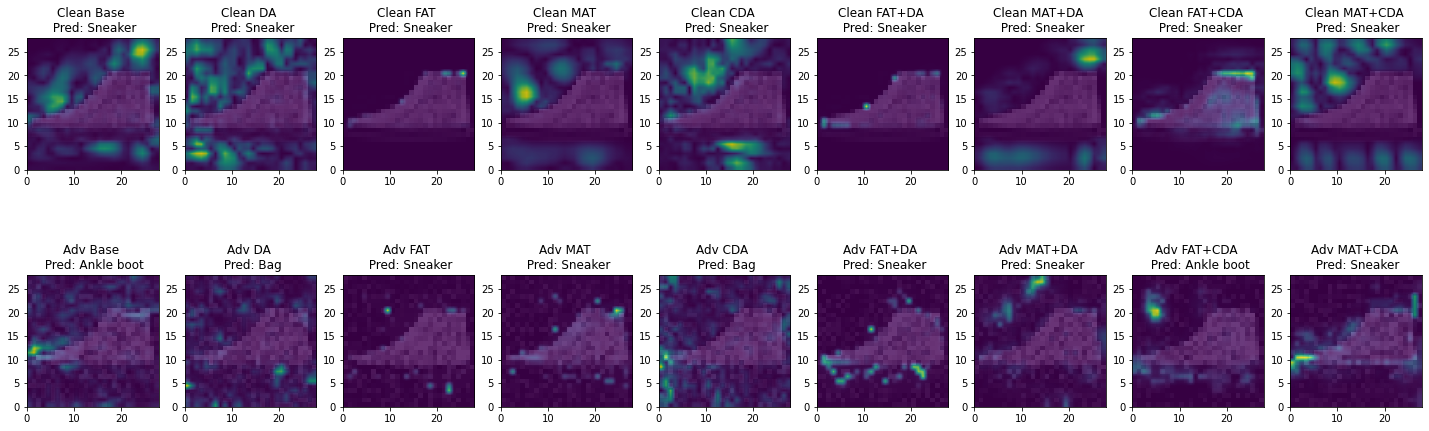

In [19]:
plot_all_models(0)

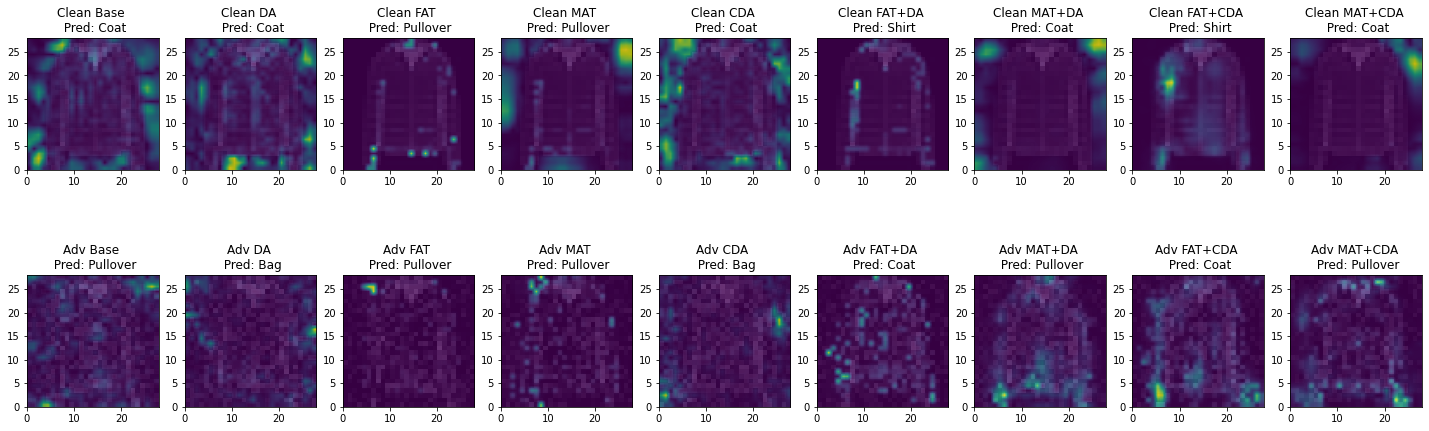

In [20]:
plot_all_models(1)

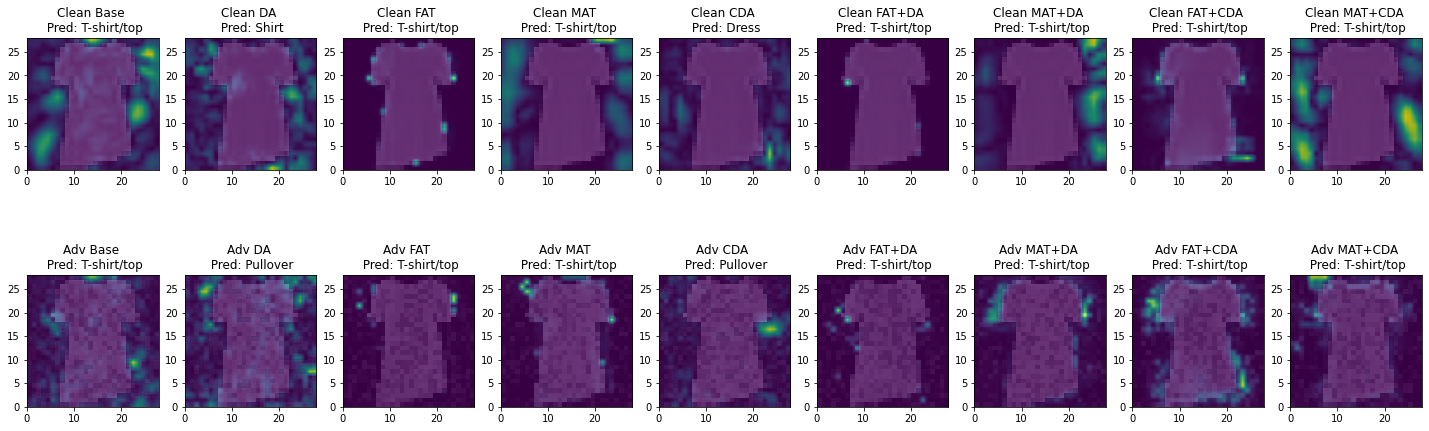

In [21]:
plot_all_models(2)

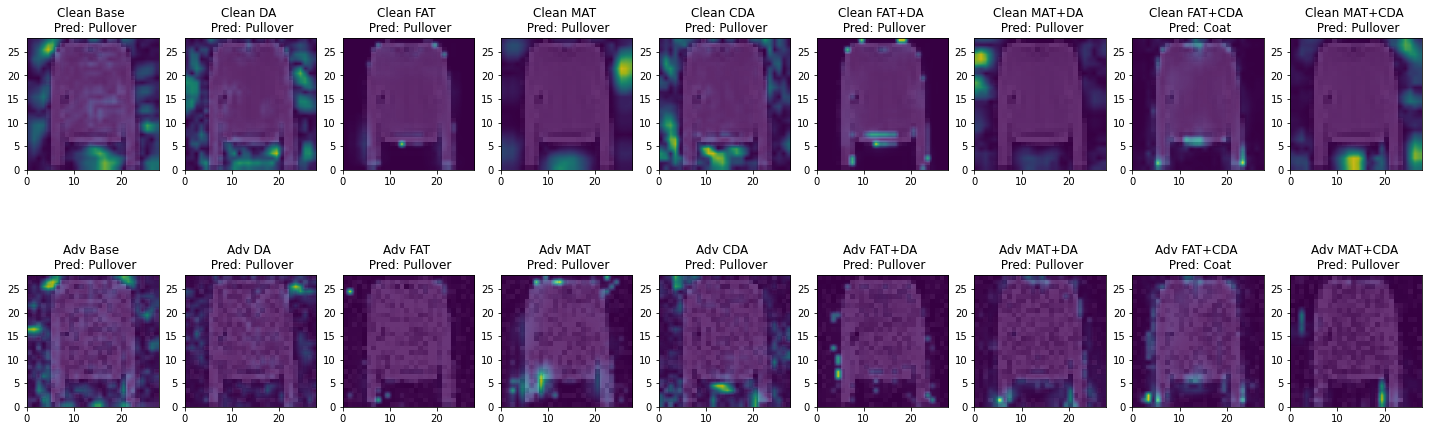

In [22]:
plot_all_models(3)

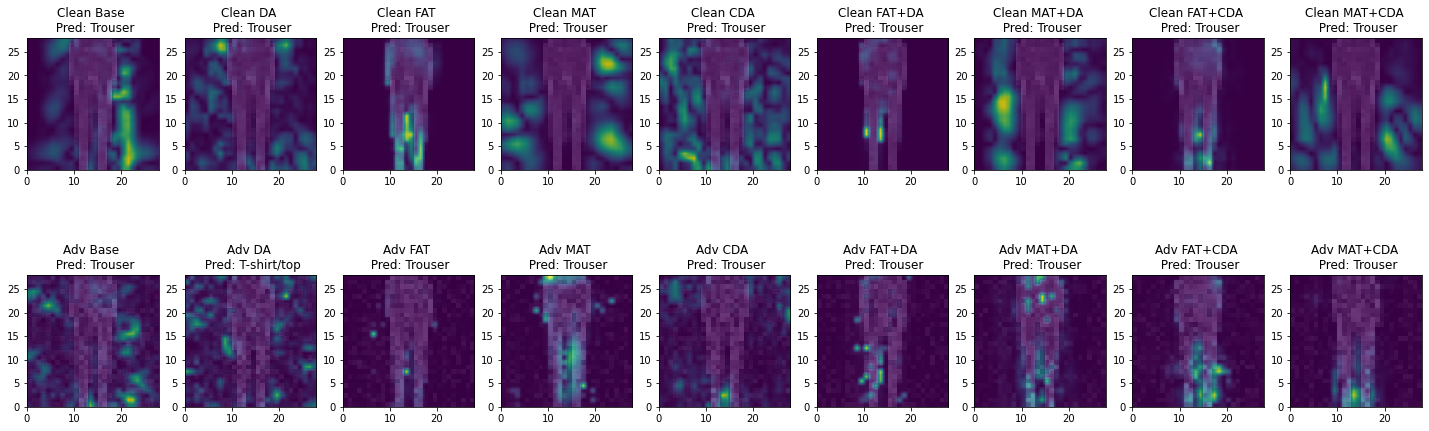

In [23]:
plot_all_models(4)

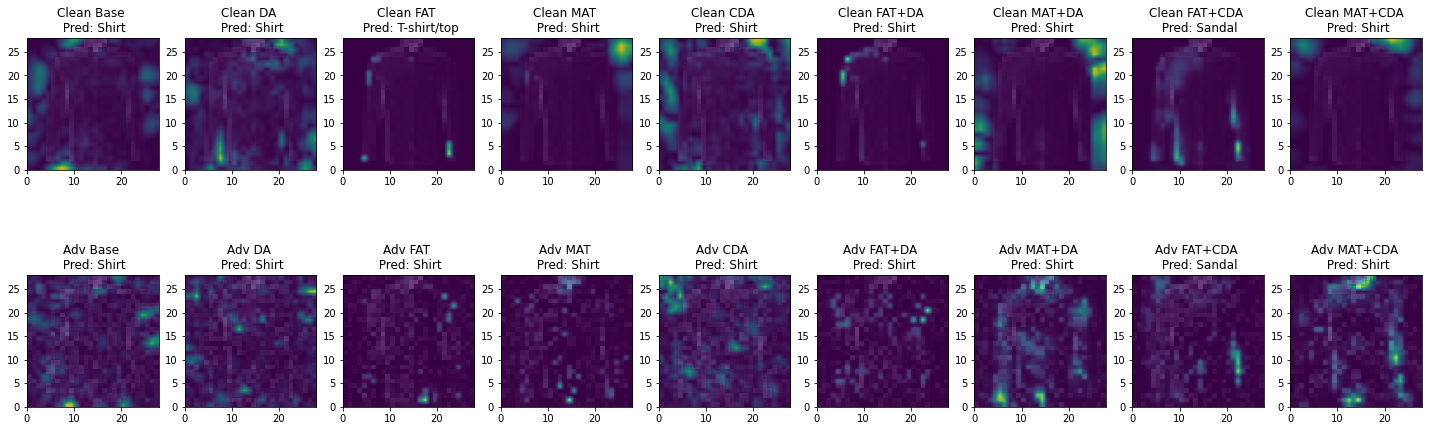

In [24]:
plot_all_models(5)

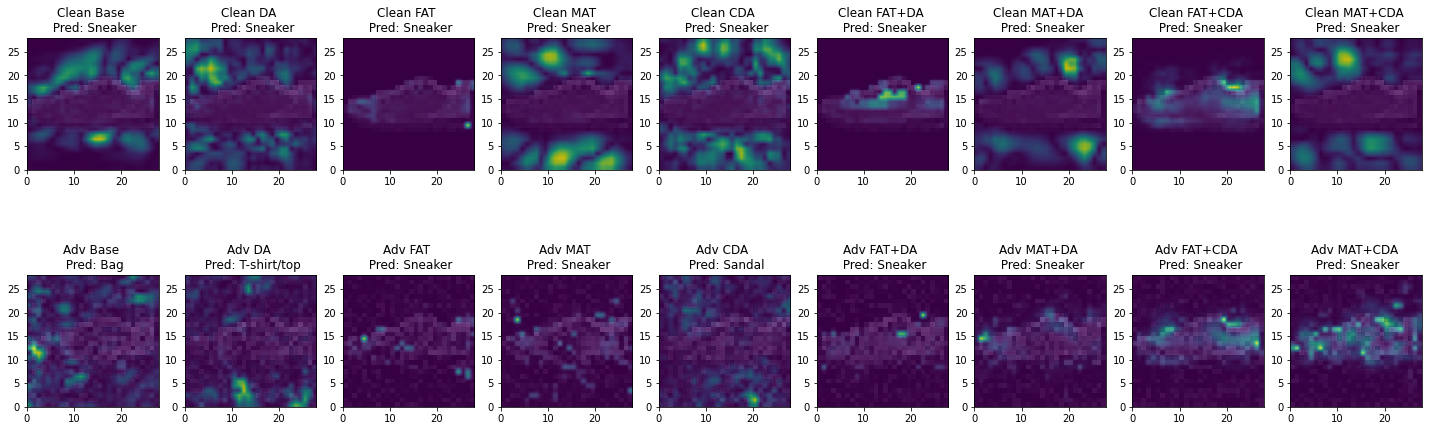

In [25]:
plot_all_models(6)

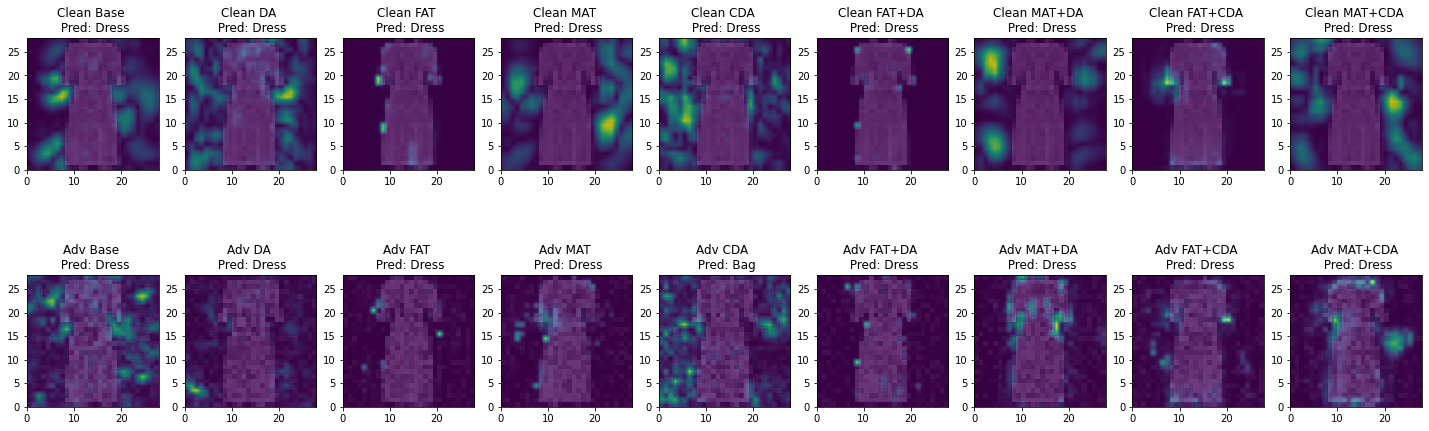

In [26]:
plot_all_models(7)

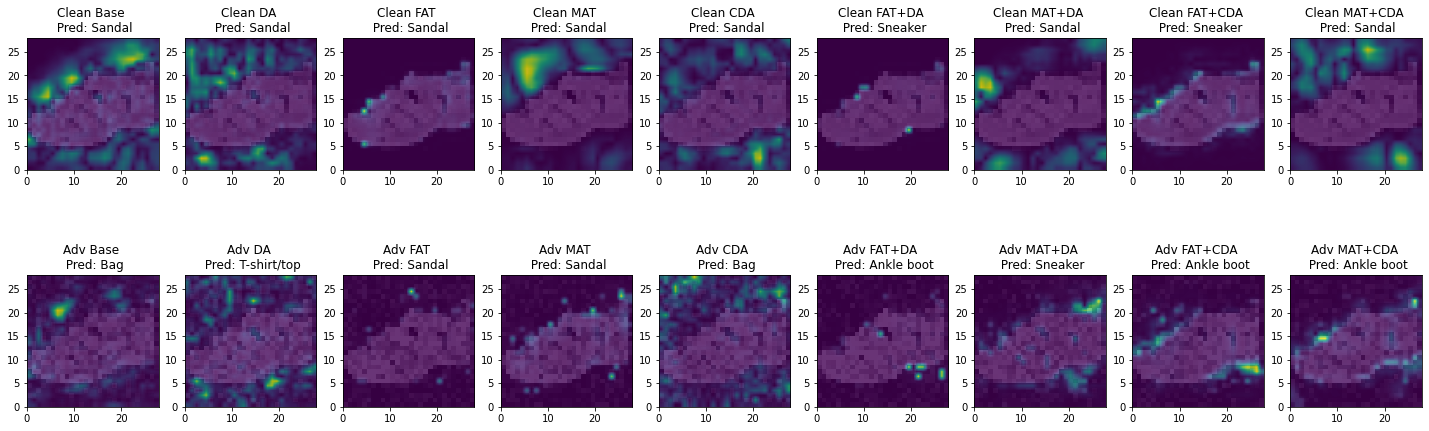

In [27]:
plot_all_models(8)

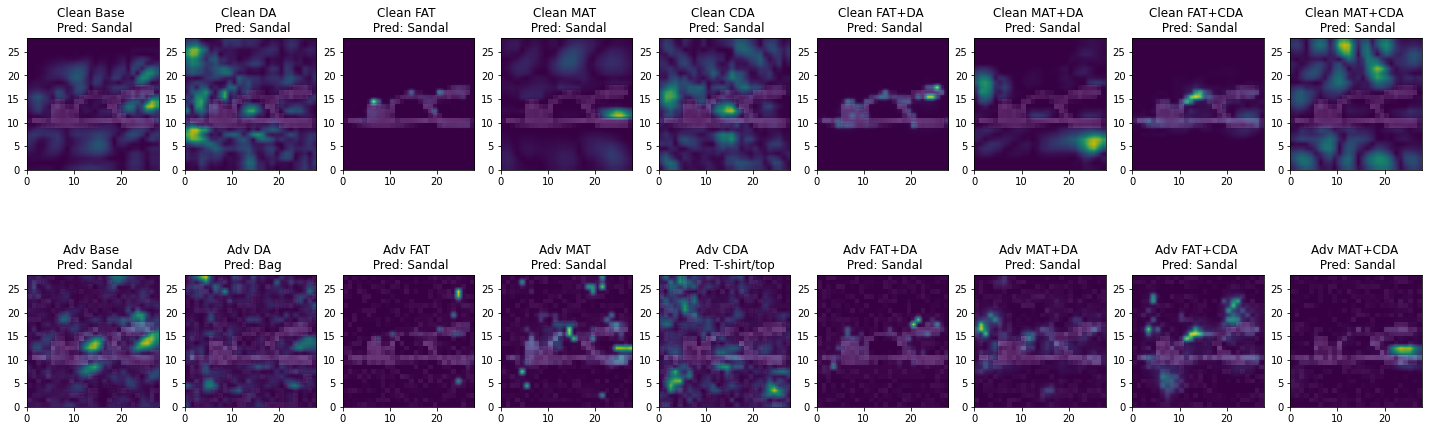

In [28]:
plot_all_models(9)